In [1]:
import os
from google.colab import files

!mkdir -p ~/.kaggle

files.upload()

!mv kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c house-prices-advanced-regression-techniques

Saving kaggle.json to kaggle.json
  0% 0.00/199k [00:00<?, ?B/s]
100% 199k/199k [00:00<00:00, 453MB/s]


In [2]:
!unzip house-prices-advanced-regression-techniques.zip

Archive:  house-prices-advanced-regression-techniques.zip
  inflating: data_description.txt    
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [3]:
import pandas as pd

df_train = pd.read_csv('train.csv')
df_sample = pd.read_csv('sample_submission.csv')
df_test=pd.read_csv('test.csv')

In [4]:
df_train = pd.get_dummies(df_train)
df_test = pd.get_dummies(df_test)

In [5]:
df_train[df_train.select_dtypes(include='bool').columns]=df_train[df_train.select_dtypes(include='bool').columns].astype('float')
df_test[df_test.select_dtypes(include='bool').columns]=df_test[df_test.select_dtypes(include='bool').columns].astype('float')

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
high_corr_cols=df_train.corr()[(abs(df_train.corr()['SalePrice'])>0.4)].index
high_corr_cols

Index(['OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'TotalBsmtSF',
       '1stFlrSF', 'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'SalePrice',
       'Neighborhood_NridgHt', 'ExterQual_Ex', 'ExterQual_Gd', 'ExterQual_TA',
       'Foundation_PConc', 'BsmtQual_Ex', 'BsmtQual_TA', 'BsmtFinType1_GLQ',
       'HeatingQC_Ex', 'KitchenQual_Ex', 'KitchenQual_TA', 'GarageFinish_Fin',
       'GarageFinish_Unf'],
      dtype='object')

In [8]:
df_train = df_train[high_corr_cols]

In [10]:
df_train.isnull().sum()

,0
OverallQual,0
YearBuilt,0
YearRemodAdd,0
MasVnrArea,8
TotalBsmtSF,0
1stFlrSF,0
GrLivArea,0
FullBath,0
TotRmsAbvGrd,0
Fireplaces,0


In [11]:
df_train=df_train.drop(['GarageYrBlt'], axis=1)

In [12]:
df_train=df_train.fillna(value=0)

In [13]:
high_corr_cols_list = high_corr_cols.tolist()
high_corr_cols_list.remove('SalePrice')
df_test = df_test[high_corr_cols_list]

In [14]:
df_test=df_test.drop(['GarageYrBlt'], axis=1)

In [15]:
df_test.isnull().sum()

,0
OverallQual,0
YearBuilt,0
YearRemodAdd,0
MasVnrArea,15
TotalBsmtSF,1
1stFlrSF,0
GrLivArea,0
FullBath,0
TotRmsAbvGrd,0
Fireplaces,0


In [16]:
df_test=df_test.fillna(value=0)

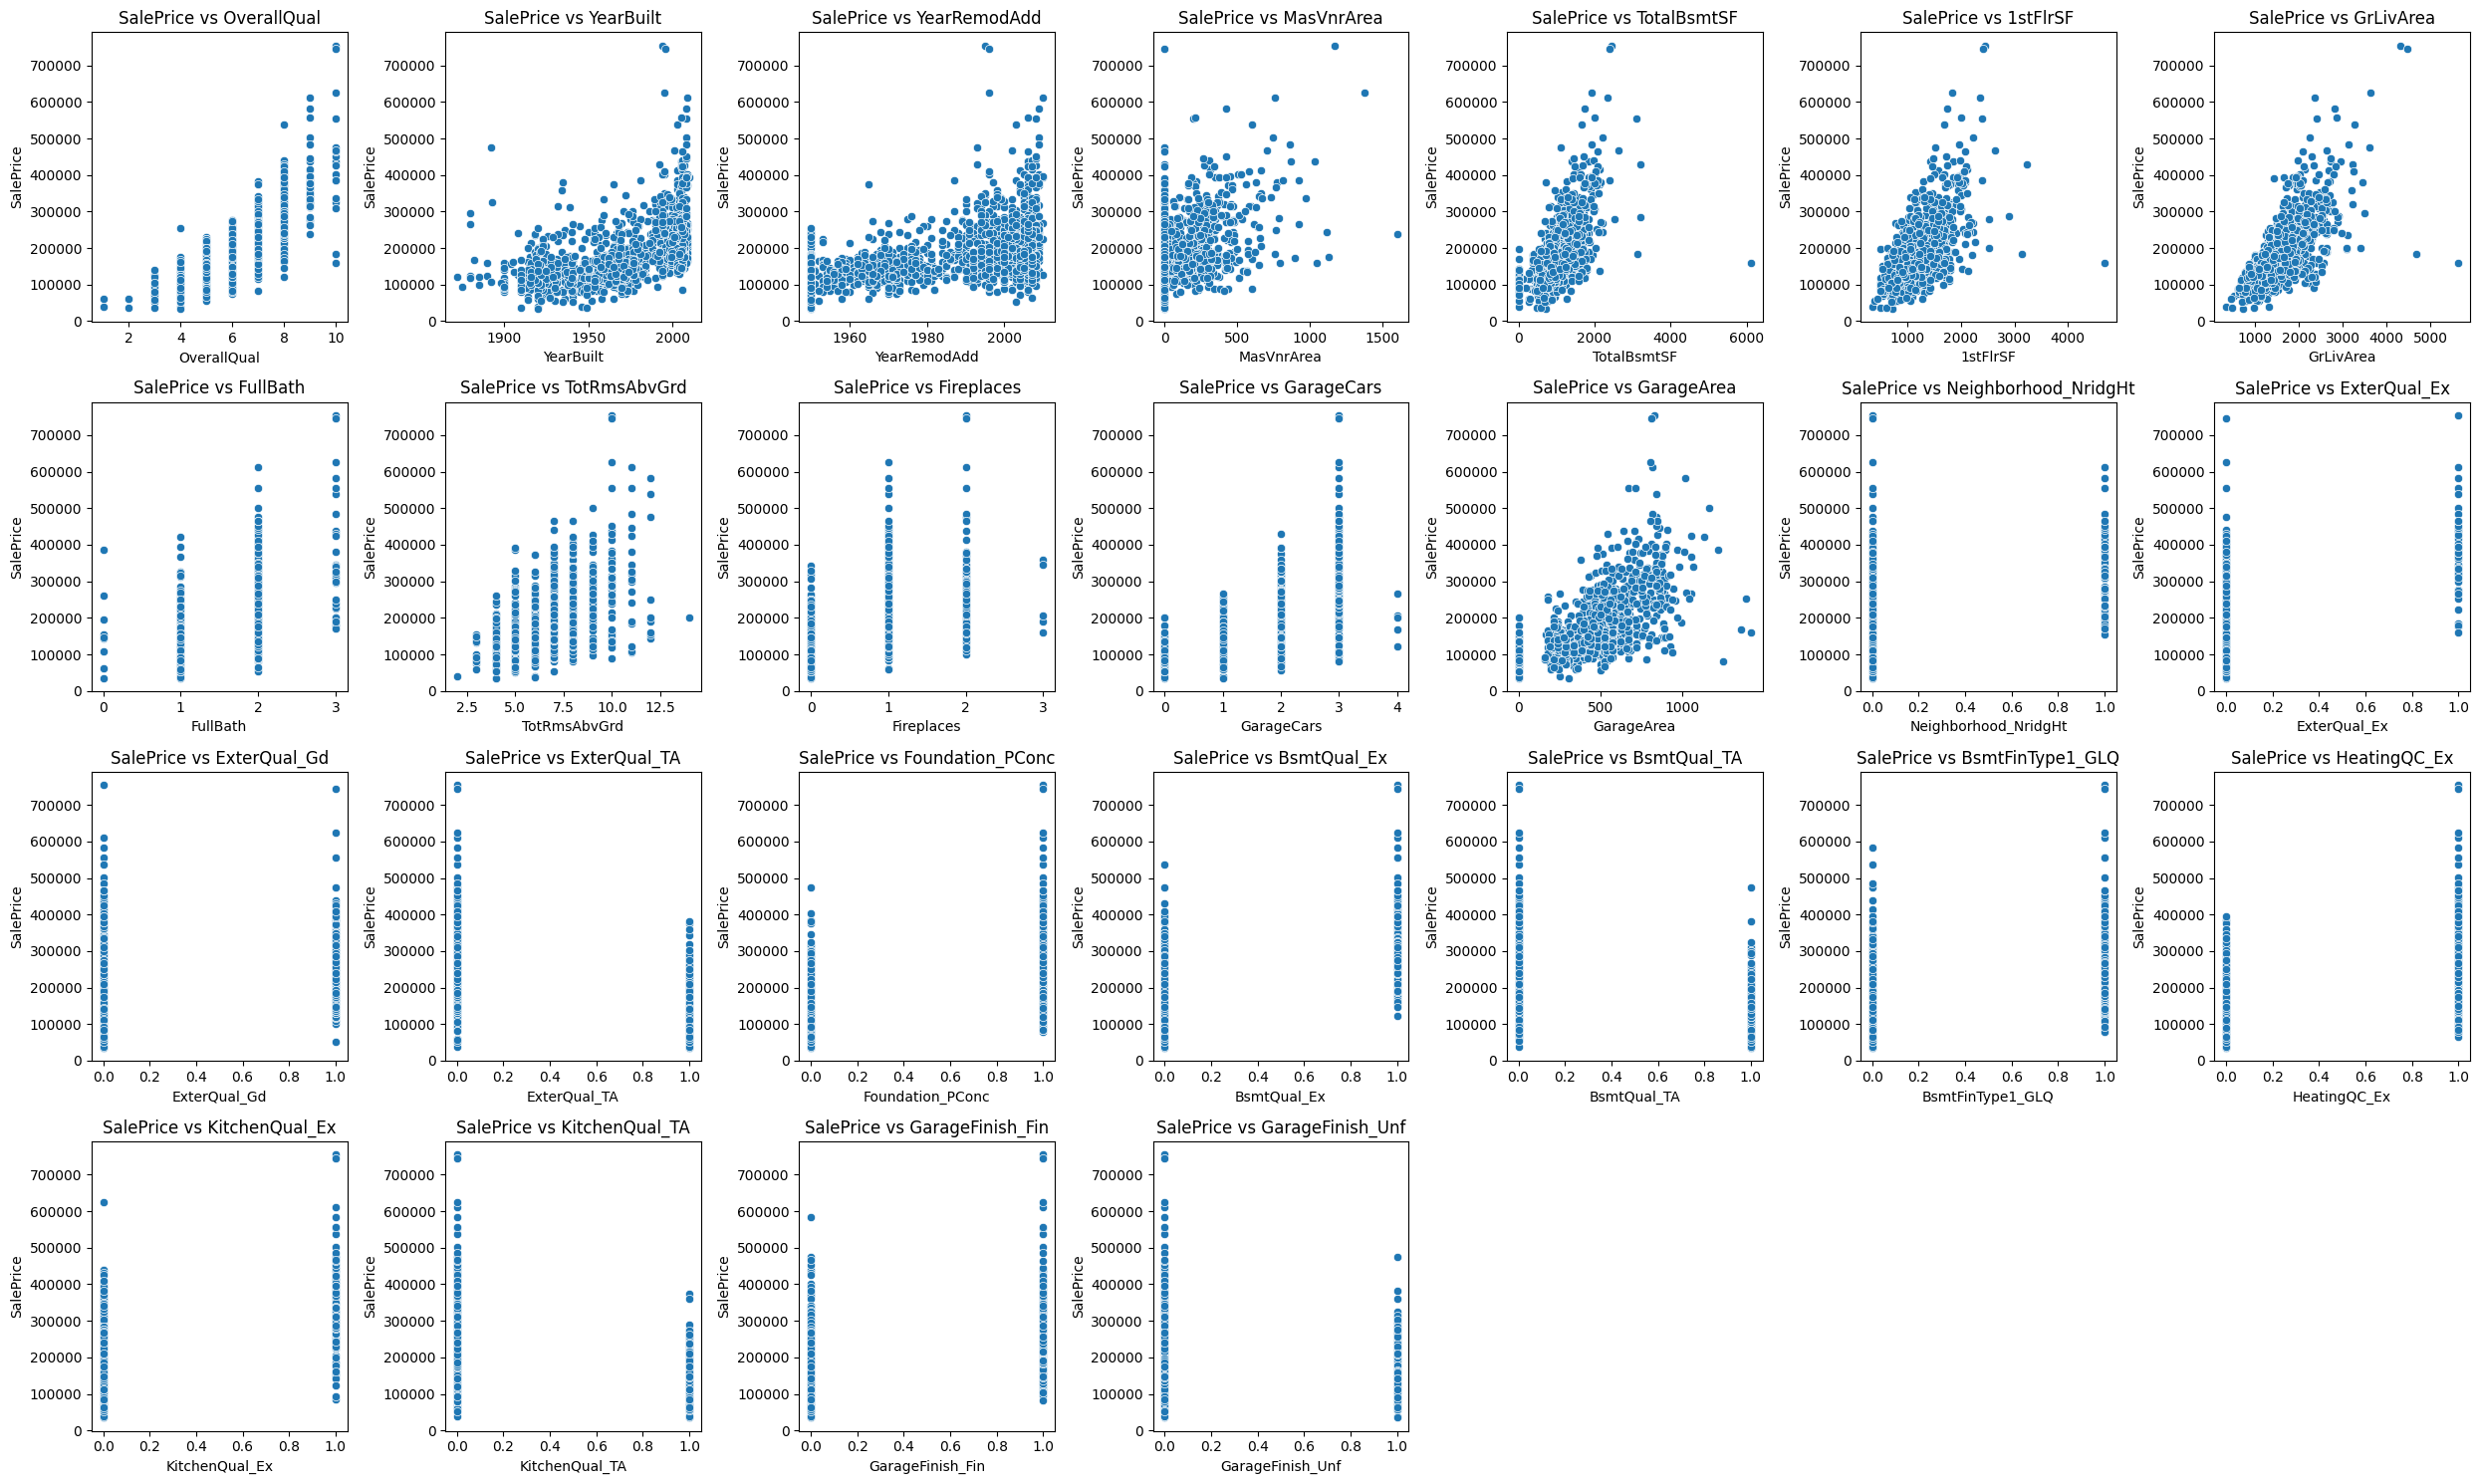

In [17]:
features_to_plot = [col for col in high_corr_cols if col != 'SalePrice' and col in df_train.columns]

n_features = len(features_to_plot)
n_rows = 4
n_cols = (n_features + n_rows - 1) // n_rows

plt.figure(figsize=(25, 15))

for i, col in enumerate(features_to_plot):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.scatterplot(data=df_train, x=col, y='SalePrice')
    plt.title(f'SalePrice vs {col}')
    plt.tight_layout()

plt.show()

In [18]:
high_corr_cols_list.remove('GarageYrBlt')

In [19]:
#Defining the training and validation features, as well as the training and validation targets. We use around 25% of the data as validation data
X_train = df_train[high_corr_cols_list].iloc[:1100,:]
X_val = df_train[high_corr_cols_list].iloc[1100:, :]
y_train = df_train['SalePrice'].iloc[:1100]
y_val = df_train['SalePrice'].iloc[1100:]

In [20]:
#We do a usual linear regresion to have a baseline to compare to
from sklearn.linear_model import LinearRegression
lr=LinearRegression()
lr.fit(X_train,y_train)
lr_pred = lr.predict(X_val)

In [21]:
from sklearn.metrics import mean_squared_log_error as msle
import numpy as np

In [23]:
print(np.sqrt(msle(y_val,np.maximum(0,lr_pred))))

0.18316756108326251


In [24]:
from sklearn.preprocessing import StandardScaler

In [25]:
ss=StandardScaler()

In [26]:
#Doing standard normalization for X_train and X_val
X_train_sd=ss.fit_transform(X_train)
X_val_sd=ss.transform(X_val)

In [27]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [28]:
#Simple neural network for a regression problem using the Keras Sequential model
nn_model=Sequential()
nn_model.add(Dense(256, activation='relu'))
nn_model.add(Dropout(0.3))
nn_model.add(Dense(256, activation= 'relu'))
nn_model.add(Dropout(0.3))
nn_model.add(Dense(128, activation= 'relu'))
nn_model.add(Dense(1))

In [29]:
nn_model.compile(optimizer='rmsprop', loss=keras.losses.MeanSquaredLogarithmicError())

In [30]:
history=nn_model.fit(X_train_sd,y_train,batch_size=32, epochs=120, validation_data=(X_val_sd,y_val))

Epoch 1/120
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 94.8904 - val_loss: 48.4277
Epoch 2/120
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 42.7336 - val_loss: 28.1403
Epoch 3/120
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 25.1099 - val_loss: 16.7101
Epoch 4/120
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 14.9095 - val_loss: 9.9095
Epoch 5/120
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.7668 - val_loss: 5.7555
Epoch 6/120
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.0814 - val_loss: 3.2380
Epoch 7/120
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.8832 - val_loss: 1.7582
Epoch 8/120
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.5255 - val_loss: 0.9376
Epoch 9/120
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8448 - val_loss: 0.5182
Epoch 10/120
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4578 - val_loss: 0.3201
Epoch 11/120
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3027 - val_loss: 0.2318
Epoch 12/120
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - l

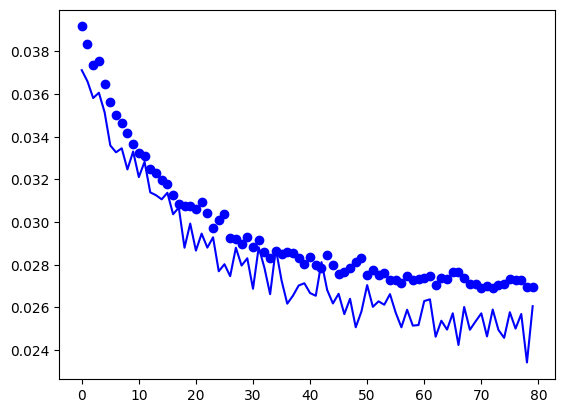

In [31]:
import matplotlib.pyplot as plt
#Plot comparing the validation loss and the loss on the training set during the last 100 epochs
plt.plot(range(80),history.history['loss'][40:],'b')
plt.plot(range(80),history.history['val_loss'][40:],'bo')

In [33]:
print(np.sqrt(nn_model.evaluate(X_val_sd,y_val)))

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0228
0.16411804212724565


In [34]:
X_tot=pd.concat([pd.DataFrame(X_train_sd),pd.DataFrame(X_val_sd)])
y_tot=pd.concat([y_train,y_val])

In [35]:
history2=nn_model.fit(X_tot,y_tot,batch_size=32, epochs=100, validation_data=(X_val_sd,y_val))

Epoch 1/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0260 - val_loss: 0.0264
Epoch 2/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0254 - val_loss: 0.0260
Epoch 3/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0266 - val_loss: 0.0260
Epoch 4/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0276 - val_loss: 0.0255
Epoch 5/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0293 - val_loss: 0.0256
Epoch 6/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0249 - val_loss: 0.0254
Epoch 7/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0249 - val_loss: 0.0251
Epoch 8/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0267 - val_loss: 0.0250
Epoch 9/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0276 - val_loss: 0.0248
Epoch 10/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0261 - val_loss: 0.0248
Epoch 11/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0248 - val_loss: 0.0247
Epoch 12/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0

In [36]:
#Computing the prediction on the test set
X_test_sd=ss.transform(df_test[high_corr_cols_list]) #Here we use the same features that where used in the prediction using X_train, and we normalize as before
nn_pred=nn_model.predict(X_test_sd) #Compute the prediction of the nn

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [37]:
#We same the prediction in a data frame, together with the ID of the house

pd.DataFrame(zip(pd.read_csv('test.csv')['Id'],nn_pred.reshape(1459,)),columns=['Id','SalePrice']).to_csv('submission.csv',index=False)

In [38]:
pd.read_csv('submission.csv')

,Id,SalePrice
0,1461,120138.720
1,1462,137331.310
2,1463,181546.390
3,1464,191580.610
4,1465,181469.300
...,...,...
1454,2915,91832.120
1455,2916,102525.020
1456,2917,152874.670
1457,2918,125833.445


In [39]:
np.sqrt(nn_model.evaluate(X_tot,y_tot))

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0181


np.float64(0.13711981529850675)